# Exercise Optical Tweezers chapter

### David Bronte Ciriza, Maria G. Donato and Onofrio M. Maragò.

Here a small tutorial solving the exercise in the chapter and showing how to analyse optical tweezers experimental data.

Explain how we have collected this data (copy paste the problem)

We first import the required libraries

In [191]:
import numpy as np
import math
import random

import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import statistics as stats
from scipy.stats import skew
import scipy.fftpack
from scipy.optimize import curve_fit

And we define some magnitudes for plotting the figures

In [192]:
VERYSMALL_SIZE=15
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl\n",

C1='#2CBDFE'
C2='#9D2EC5'
C3='#F5B14C'

We define function to load our data:

In [193]:
def ReadingFileWithTime(FileName):

    f=open(FileName, "r")
    content=f.readlines()

    s=len(content)

    t=np.zeros(s)
    x_volt_meas=np.zeros(s)
    y_volt_meas=np.zeros(s)
    z_volt_meas=np.zeros(s)
       
    for i in range (s):
        row=content[i].split("\t")
        t[i]=float(row[1])
        x_volt_meas[i]=float(row[2])
        y_volt_meas[i]=float(row[3])
        z_volt_meas[i]=float(row[4])
    
    positions_Volts=[t,x_volt_meas,y_volt_meas,z_volt_meas]
    return positions_Volts

We load one file of data:

In [194]:
FolderThatContainsFiles = ".\\Exercise"
my_file = os.path.join(FolderThatContainsFiles, 'D0b2_10.txt')
Data=ReadingFileWithTime(my_file)

We plot the voltage measurements obtained from the QPD

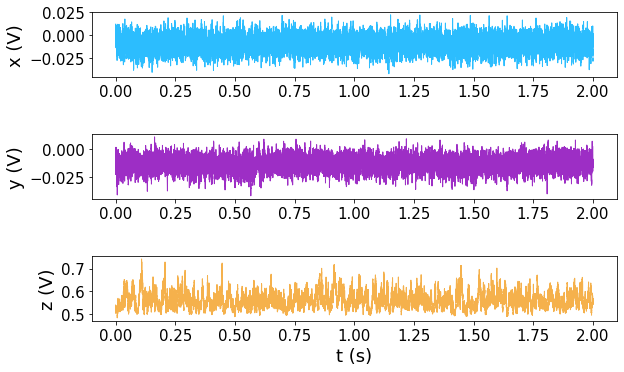

In [195]:
fig = plt.figure()

ax1 = plt.subplot(3,1,1)
ax1.plot(Data[0],Data[1], linewidth=1,c=C1)
ax1.set_ylabel("x (V)")

# and a reference to the second axis
ax2 = plt.subplot(3,1,2)
ax2.plot(Data[0],Data[2], linewidth=1,c=C2)
ax2.set_ylabel("y (V)")

ax3 = plt.subplot(3,1,3)
ax3.plot(Data[0],Data[3], linewidth=1,c=C3)
ax3.set_ylabel("z (V)")
ax3.set_xlabel("t (s)")

fig.tight_layout()


plt.gcf().set_size_inches(10, 6)

We substract the mean:

In [196]:
DataMeanSubstracted=[Data[0],Data[1]-Data[1].mean(),Data[2]-Data[2].mean(),Data[3]-Data[3].mean()]

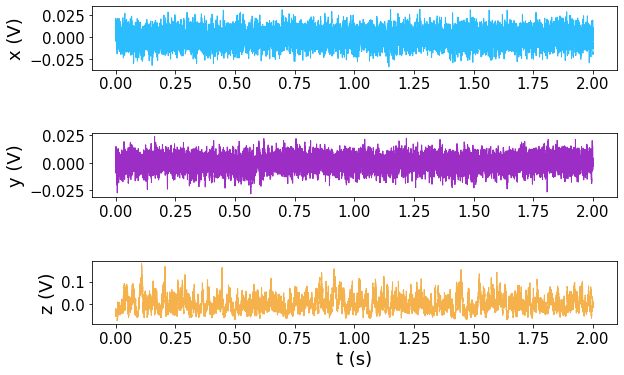

In [197]:
fig = plt.figure()


ax1 = plt.subplot(3,1,1)
ax1.plot(DataMeanSubstracted[0],DataMeanSubstracted[1], linewidth=1,c=C1)
ax1.set_ylabel("x (V)")

# and a reference to the second axis
ax2 = plt.subplot(3,1,2)
ax2.plot(DataMeanSubstracted[0],DataMeanSubstracted[2], linewidth=1,c=C2)
ax2.set_ylabel("y (V)")

ax3 = plt.subplot(3,1,3)
ax3.plot(DataMeanSubstracted[0],DataMeanSubstracted[3], linewidth=1,c=C3)
ax3.set_ylabel("z (V)")
ax3.set_xlabel("t (s)")

fig.tight_layout()

plt.gcf().set_size_inches(10, 6)

We can already see that the fluctuations across the $z$ axis are much larger than across the $x$ and $y$ directions.

Let's plot an histogram of the distribution. How does it look?

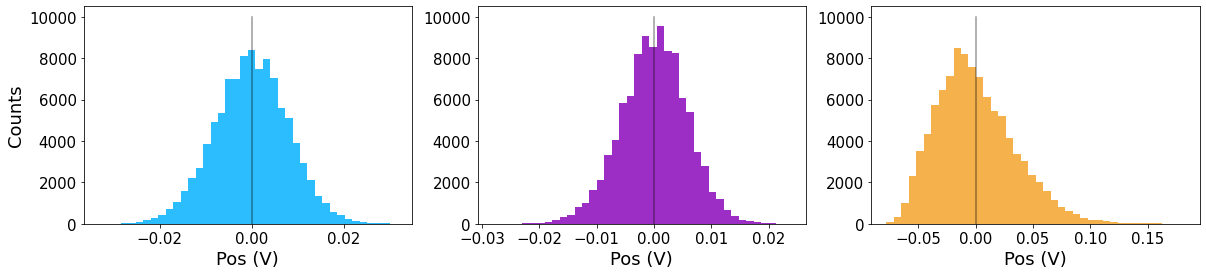

In [198]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.hist(DataMeanSubstracted[1],40,color=C1)
ax1.plot([0,0],[0,10000],c='k',alpha=0.4)
ax1.set_ylabel("Counts")
ax1.set_xlabel("Pos (V)")

# and a reference to the second axis
ax2 = plt.subplot(1,3,2)
ax2.hist(DataMeanSubstracted[2],40,color=C2)
ax2.plot([0,0],[0,10000],c='k',alpha=0.4)
ax2.set_xlabel("Pos (V)")

ax3 = plt.subplot(1,3,3)
ax3.hist(DataMeanSubstracted[3],40,color=C3)
ax3.plot([0,0],[0,10000],c='k',alpha=0.4)
ax3.set_xlabel("Pos (V)")

#fig.tight_layout()

plt.gcf().set_size_inches(20, 4)

Now we are ready to start calibrating the optical trap

Let's define the parameters of our experiment

In [199]:
kB=1.3806E-23       # [(kg·m^2)/(K·s^2)]
T = 273+20          # [K]
Radius = 1E-6    # [m]
#Check viscosity value
Viscosity = 0.00002414*10**(247.8/(-140+T))  # [Pa·s]
Gamma = 6*math.pi*Viscosity*Radius

## Power spectrum


We start by calculating the power spectrum. We focus on one single measurement (for simplicity)

In [200]:
"""
Function to compute the Power Spectrum.
Input: Frequency of sampling [Hz], Variable[AnyUnits]
Output: [Freqs, Power Spectrum]

"""

def PS(frequency_of_sampling,position_Volts):
    
    s=len(position_Volts)

    freq=np.arange(0,frequency_of_sampling/2,frequency_of_sampling/(s))

    FFT=scipy.fftpack.fft(position_Volts)
    FFT_one_side=FFT[0:int(s/2)]
    
    psd=2*((np.abs(FFT_one_side))**2)/(frequency_of_sampling*s)
    
    return([freq[1:],psd[1:]])

We calculate the sampling frequency

In [201]:
freq_sampling=1/(DataMeanSubstracted[0][1]-DataMeanSubstracted[0][0])

And we compute the power spectrum

In [202]:
PS_calculatedX=PS(freq_sampling,DataMeanSubstracted[1])
PS_calculatedY=PS(freq_sampling,DataMeanSubstracted[2])
PS_calculatedZ=PS(freq_sampling,DataMeanSubstracted[3])

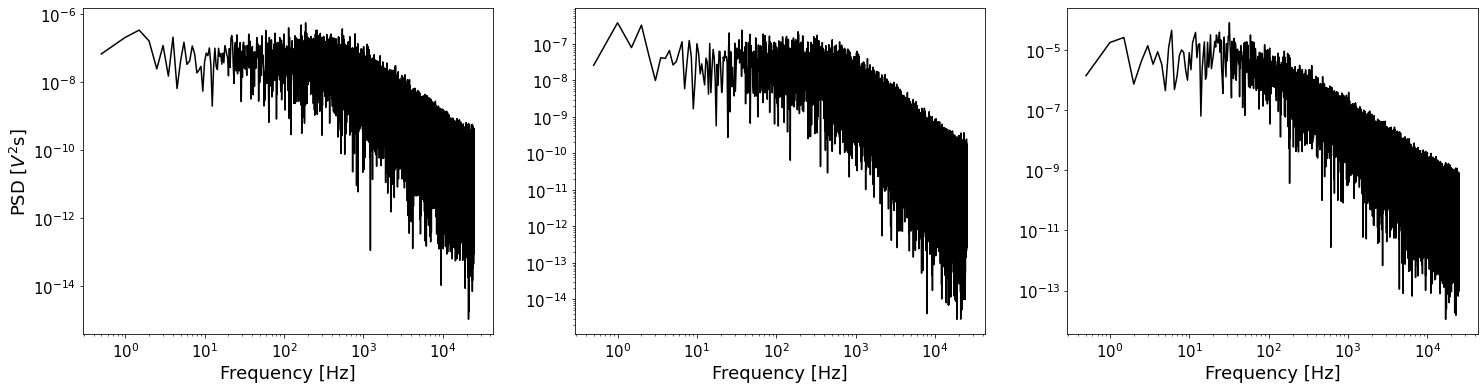

In [203]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")

ax2 = plt.subplot(1,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")

ax3 = plt.subplot(1,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

We define the fitting function and the function we will use to obtain the parameters after the fitting.

In [204]:
def FuncToFitPS(x, a, b):
    return a /( (x**2)+(b**2) )

In [205]:
def FittingPS(frequencies,psd,NPoints):

    popt, pcov = curve_fit(FuncToFitPS,frequencies[0:NPoints],psd[0:NPoints],p0=[10000000,444])
    
    PS_K_SI=2*Gamma*np.pi*popt[1]   
    PS_Beta=np.sqrt( FuncToFitPS(0,popt[0],popt[1])*popt[1]*popt[1]*np.pi*Gamma/(kB*T)     )
    #PS_Beta=1/np.sqrt( (kB*T)/(popt[0]*Gamma*np.pi*np.pi)     )
    
    ToReturn0=[frequencies[0:NPoints],FuncToFitPS(frequencies[0:NPoints], popt[0], popt[1])]
    ToReturn1=[PS_K_SI,PS_Beta]
    
    return([ToReturn0,ToReturn1])

In [206]:
Fitted_PS_X=FittingPS(PS_calculatedX[0],PS_calculatedX[1],10000)
Fitted_PS_Y=FittingPS(PS_calculatedY[0],PS_calculatedY[1],10000)
Fitted_PS_Z=FittingPS(PS_calculatedZ[0],PS_calculatedZ[1],10000)

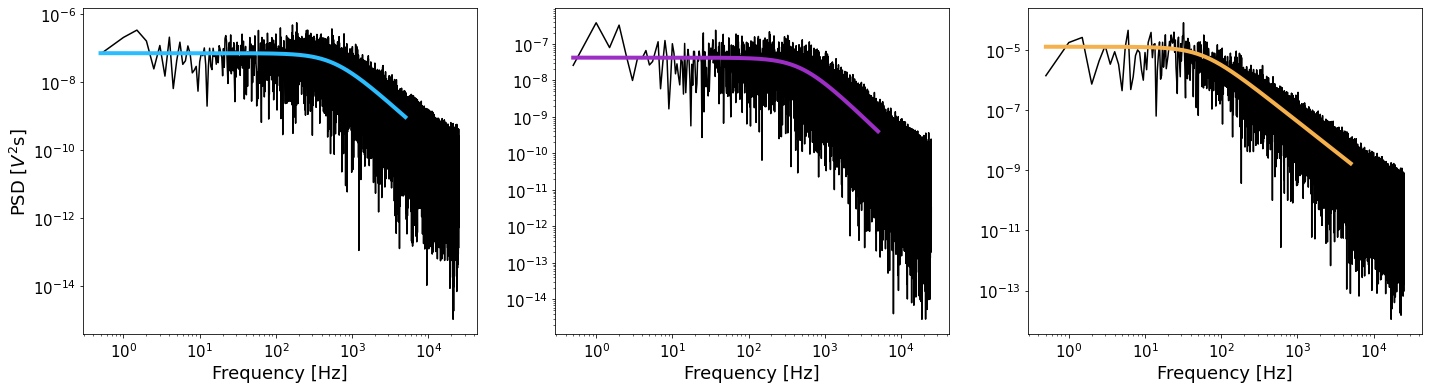

In [238]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.plot(Fitted_PS_X[0][0], Fitted_PS_X[0][1], linewidth=4, c=C1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")

ax2 = plt.subplot(1,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.plot(Fitted_PS_Y[0][0], Fitted_PS_Y[0][1], linewidth=4, c=C2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")

ax3 = plt.subplot(1,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.plot(Fitted_PS_Z[0][0], Fitted_PS_Z[0][1], linewidth=4, c=C3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

plt.savefig('.\\PS.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [209]:
Fitted_PS_X[1][0]

6.898475128864362e-05

In [210]:
Fitted_PS_Y[1][0]

5.857617188758282e-05

In [211]:
Fitted_PS_Z[1][0]

6.808258575947718e-06

The value of $\beta\,[V/m]$

In [212]:
Fitted_PS_X[1][1]

594311.0395101135

In [213]:
Fitted_PS_Y[1][1]

387873.3912106273

In [214]:
Fitted_PS_Z[1][1]

794072.3202039044

## Autocorrelation function

We calculate now the autocorrelation function. 

In [215]:
"""
Function to compute the Autocorrelation Function.
Input: Time[s],Variable[AnyUnits],MaxTimeStepsCompute
Output: [Time,AutocorrelationFunction]

"""

def ACF(time,position_Volts,MaxTimeDistance):

    AutoCorrelationFunction=np.zeros(MaxTimeDistance)
    
    s=len(position_Volts)
    
    sum1=0

    for i in range (0,MaxTimeDistance):
        for j in range(0,s-i):
            aux1=position_Volts[j+i]*position_Volts[j]
            sum1=sum1+aux1;
            AutoCorrelationFunction[i]=(1/(s-i))*sum1
        sum1=0
    
    t_ACF=time[0:int(MaxTimeDistance)]
    
    AutoCorrelationFunction_def=AutoCorrelationFunction[0:(s)]
    t_ACF_def=t_ACF[0:(s)]

    return([t_ACF_def,AutoCorrelationFunction_def])

The method used to compute the ACF is very slow, you can use prebuilt functions to improve it!

In [217]:
ACF_calculatedX=ACF(DataMeanSubstracted[0],DataMeanSubstracted[1],400)
ACF_calculatedY=ACF(DataMeanSubstracted[0],DataMeanSubstracted[2],400)
ACF_calculatedZ=ACF(DataMeanSubstracted[0],DataMeanSubstracted[3],800)

We observe the exponential decay we are expecting. 

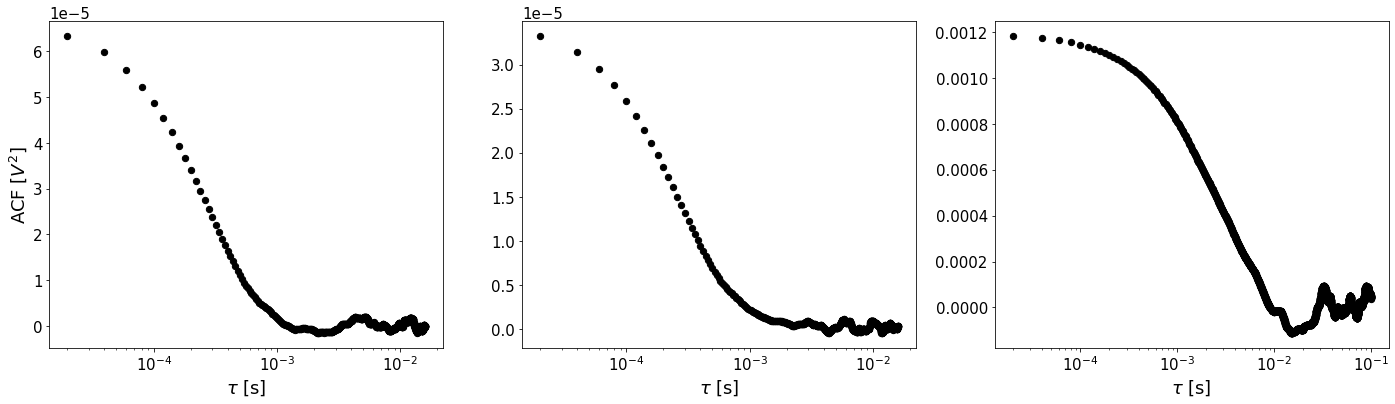

In [226]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax1.set_xscale('log')
ax1.set_ylabel("ACF [$V^2$]")
ax1.set_xlabel(r'$\tau$ [s]')

ax2 = plt.subplot(1,3,2)
ax2.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau$ [s]')

ax3 = plt.subplot(1,3,3)
ax3.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\tau$ [s]')

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

Now that we have the ACF we need to fit it to the theoretical expression in order to obtain the parameters for the stiffness $k$ and for the conversion factor $\beta$

In [219]:
def FuncToFitACF(x, a, b,c):
    return (a * np.exp(-b * x))+c

In [220]:
"""
Function to fit the experimental ACF to the theoretical ACF.
Input: Time[s],ACF values, Number of time steps that we want to consider for the fitting
Output: [Time considered for fitting, Fitted curve]
        [Value of K [N/m], Value of beta [V/m]]

"""

def FittingACF(t_ACF_def,AutoCorrelationFunction_def,NPoints):

    popt, pcov = curve_fit(FuncToFitACF,t_ACF_def[0:NPoints],AutoCorrelationFunction_def[0:NPoints],p0=[0.00008,700,0])
    
    ACF_K_SI=popt[1]*Gamma
    ACF_Beta=np.sqrt((popt[0]*ACF_K_SI)/(kB*T))
    
    ToReturn0=[t_ACF_def[0:NPoints],FuncToFitACF(t_ACF_def[0:NPoints], popt[0], popt[1],popt[2])]
    ToReturn1=[ACF_K_SI,ACF_Beta]
    
    return([ToReturn0,ToReturn1])

In [221]:
Fitted_ACF_X=FittingACF(ACF_calculatedX[0],ACF_calculatedX[1],300)
Fitted_ACF_Y=FittingACF(ACF_calculatedY[0],ACF_calculatedY[1],300)
Fitted_ACF_Z=FittingACF(ACF_calculatedZ[0],ACF_calculatedZ[1],400)

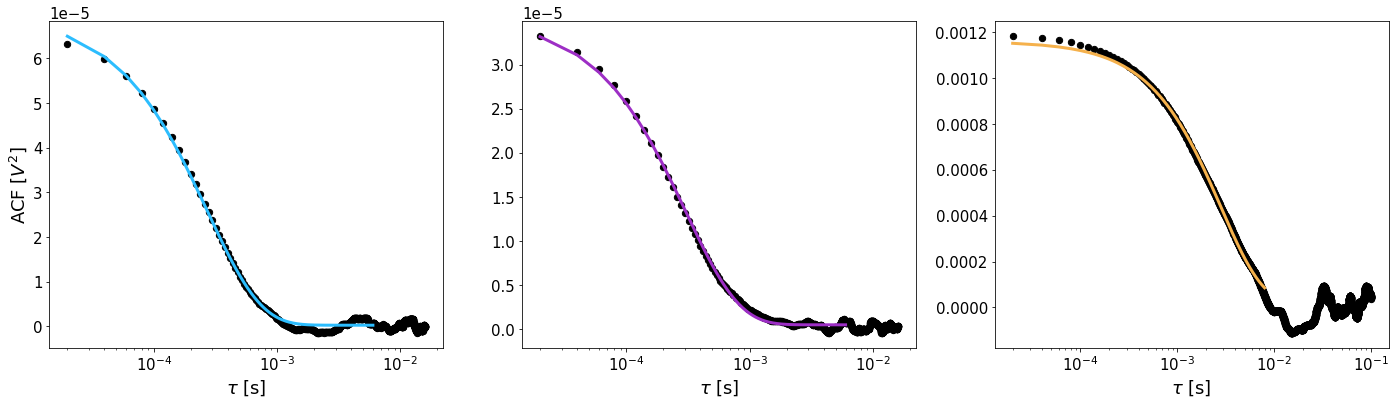

In [239]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax1.plot(Fitted_ACF_X[0][0], Fitted_ACF_X[0][1], linewidth=3, c=C1)
ax1.set_xscale('log')
ax1.set_ylabel("ACF [$V^2$]")
ax1.set_xlabel(r'$\tau$ [s]')

ax2 = plt.subplot(1,3,2)
ax2.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax2.plot(Fitted_ACF_Y[0][0], Fitted_ACF_Y[0][1], linewidth=3, c=C2)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau$ [s]')

ax3 = plt.subplot(1,3,3)
ax3.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax3.plot(Fitted_ACF_Z[0][0], Fitted_ACF_Z[0][1], linewidth=3, c=C3)
ax3.set_xscale('log')
ax3.set_xlabel(r'$\tau$ [s]')

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

plt.savefig('.\\ACF.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [228]:
Fitted_ACF_X[1][0]

6.96018737168294e-05

In [229]:
Fitted_ACF_Y[1][0]

6.237479454787732e-05

In [230]:
Fitted_ACF_Z[1][0]

6.694198418821306e-06

The value of $\beta \, [V/m]$

In [231]:
Fitted_ACF_X[1][1]

1094301.1402910848

In [232]:
Fitted_ACF_Y[1][1]

733852.4350936494

In [233]:
Fitted_ACF_Z[1][1]

1373638.0809098133

## FORMA

Let us focus now on FORMA

In [234]:
def FORMAMethod(dt,Position):
    
    position=Position
    s=len(position)

    aux1=position

    Speeds=np.zeros(s-1)

    for i in range (s-1):
        Speeds[i]=(aux1[i+1]-aux1[i])/dt
            
    f_n=Speeds*Gamma

    positions_n_by_f_n=position[0:s-1]*f_n
    x_n_squared=position[0:s-1]*position[0:s-1]

    K_FORMA=(sum(positions_n_by_f_n))/sum(x_n_squared)
    
    ToReturn0=[position[0:s-1],f_n]
    ToReturn1=[K_FORMA]
    
    return([ToReturn0,ToReturn1])

In [235]:
dt=DataMeanSubstracted[0][1]-DataMeanSubstracted[0][0]

In [236]:
FORMA_calculatedX=FORMAMethod(dt,DataMeanSubstracted[1])
FORMA_calculatedY=FORMAMethod(dt,DataMeanSubstracted[2])
FORMA_calculatedZ=FORMAMethod(dt,DataMeanSubstracted[3])

We plot $f_n$ vs $x_n$

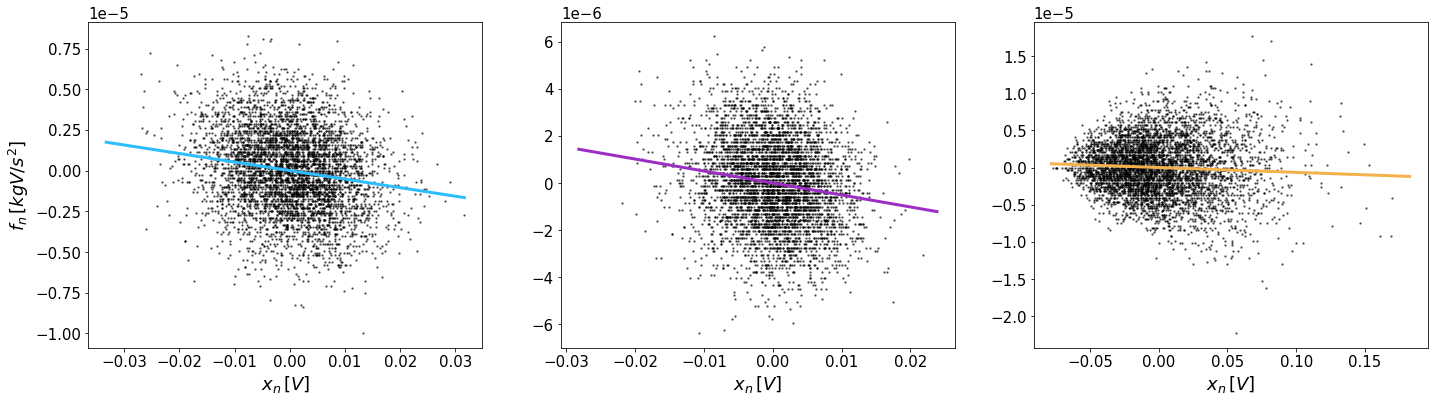

In [255]:
fig = plt.figure()

ax1 = plt.subplot(1,3,1)
ax1.scatter(FORMA_calculatedX[0][0][::20],FORMA_calculatedX[0][1][::20],s=2,c='k',alpha=0.5)
ax1.plot([min(FORMA_calculatedX[0][0]),max(FORMA_calculatedX[0][0])],[min(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0],max(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0]],linewidth=3,c=C1)
ax1.set_ylabel("$f_n\,[kg V/s^2]$")
ax1.set_xlabel("$x_n\,[V]$")

ax2 = plt.subplot(1,3,2)
ax2.scatter(FORMA_calculatedY[0][0][::20],FORMA_calculatedY[0][1][::20],s=2,c='k',alpha=0.5)
ax2.plot([min(FORMA_calculatedY[0][0]),max(FORMA_calculatedY[0][0])],[min(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0],max(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0]],linewidth=3,c=C2)
ax2.set_xlabel("$y_n\,[V]$")

ax3 = plt.subplot(1,3,3)
ax3.scatter(FORMA_calculatedZ[0][0][::20],FORMA_calculatedZ[0][1][::20],s=2,c='k',alpha=0.5)
ax3.plot([min(FORMA_calculatedZ[0][0]),max(FORMA_calculatedZ[0][0])],[min(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0],max(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0]],linewidth=3,c=C3)
ax3.set_xlabel("$z_n\,[V]$")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

#plt.savefig('.\\FORMA.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [102]:
abs(FORMA_calculatedX[1][0])

5.246317435463358e-05

In [103]:
abs(FORMA_calculatedY[1][0])

5.080943040127781e-05

In [106]:
abs(FORMA_calculatedZ[1][0])

6.541490910568713e-06

In [ ]:
fig = plt.figure()

ax1 = plt.subplot(3,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.plot(Fitted_PS_X[0][0], Fitted_PS_X[0][1], linewidth=4, c=C1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")

ax2 = plt.subplot(3,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.plot(Fitted_PS_Y[0][0], Fitted_PS_Y[0][1], linewidth=4, c=C2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")

ax3 = plt.subplot(3,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.plot(Fitted_PS_Z[0][0], Fitted_PS_Z[0][1], linewidth=4, c=C3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")


ax4 = plt.subplot(3,3,4)
ax4.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax4.plot(Fitted_ACF_X[0][0], Fitted_ACF_X[0][1], linewidth=3, c=C1)
ax4.set_xscale('log')
ax4.set_ylabel("ACF [$V^2$]")
ax4.set_xlabel(r'$\tau$ [s]')

ax5 = plt.subplot(3,3,5)
ax5.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax5.plot(Fitted_ACF_Y[0][0], Fitted_ACF_Y[0][1], linewidth=3, c=C2)
ax5.set_xscale('log')
ax5.set_xlabel(r'$\tau$ [s]')

ax6 = plt.subplot(3,3,6)
ax6.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax6.plot(Fitted_ACF_Z[0][0], Fitted_ACF_Z[0][1], linewidth=3, c=C3)
ax6.set_xscale('log')
ax6.set_xlabel(r'$\tau$ [s]')


ax7 = plt.subplot(3,3,7)
ax7.scatter(FORMA_calculatedX[0][0][::20],FORMA_calculatedX[0][1][::20],s=2,c='k',alpha=0.5)
ax7.plot([min(FORMA_calculatedX[0][0]),max(FORMA_calculatedX[0][0])],[min(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0],max(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0]],linewidth=3,c=C1)
ax7.set_ylabel("$f_n\,[kg V/s^2]$")
ax7.set_xlabel("$x_n\,[V]$")

ax8 = plt.subplot(3,3,8)
ax8.scatter(FORMA_calculatedY[0][0][::20],FORMA_calculatedY[0][1][::20],s=2,c='k',alpha=0.5)
ax8.plot([min(FORMA_calculatedY[0][0]),max(FORMA_calculatedY[0][0])],[min(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0],max(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0]],linewidth=3,c=C2)
ax8.set_xlabel("$y_n\,[V]$")

ax9 = plt.subplot(3,3,9)
ax9.scatter(FORMA_calculatedZ[0][0][::20],FORMA_calculatedZ[0][1][::20],s=2,c='k',alpha=0.5)
ax9.plot([min(FORMA_calculatedZ[0][0]),max(FORMA_calculatedZ[0][0])],[min(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0],max(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0]],linewidth=3,c=C3)
ax9.set_xlabel("$z_n\,[V]$")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 18)

plt.savefig('.\\AllTogether.svg', format='svg', transparent=True,bbox_inches='tight')

## Averaging

Now we have fully analysed one measurement but we need to analyze more in order to get some statistics. We have 10 files, let's go!

We import the data and substract the mean

In [121]:
AllData=np.zeros([10,4,100000])
FolderThatContainsFiles = ".\\Exercise"

for i in range (1,11):
    my_file = os.path.join(FolderThatContainsFiles, 'D0b2_'+str(i)+'.txt')
    Data=ReadingFileWithTime(my_file)
    DataMeanSubstracted=[Data[0],Data[1]-Data[1].mean(),Data[2]-Data[2].mean(),Data[3]-Data[3].mean()]
    AllData[i-1]=DataMeanSubstracted

### Power spectrum 

In [166]:
def ExtractKandBetaFromPS(DataImported,NumberPointsToFitPS):
    
    freq_sampling=1/(DataImported[0][1]-DataImported[0][0])

    PS_calculatedX=PS(freq_sampling,DataImported[1])
    PS_calculatedY=PS(freq_sampling,DataImported[2])
    PS_calculatedZ=PS(freq_sampling,DataImported[3])

    Fitted_PS_X=FittingPS(PS_calculatedX[0],PS_calculatedX[1],NumberPointsToFitPS)
    Fitted_PS_Y=FittingPS(PS_calculatedY[0],PS_calculatedY[1],NumberPointsToFitPS)
    Fitted_PS_Z=FittingPS(PS_calculatedZ[0],PS_calculatedZ[1],NumberPointsToFitPS)

    K_PS=[Fitted_PS_X[1][0],Fitted_PS_Y[1][0],Fitted_PS_Z[1][0]]
    Beta_PS=[Fitted_PS_X[1][1],Fitted_PS_Y[1][1],Fitted_PS_Z[1][1]]

    return([K_PS,Beta_PS])

In [170]:
ValuesPS=np.zeros([10,2,3])

for i in range (0,10):
    Values=ExtractKandBetaFromPS(AllData[i],10000)
    ValuesPS[i,0]=Values[0]
    ValuesPS[i,1]=Values[1]

In [181]:
K_PS_Av=np.mean(ValuesPS[:,0,:],axis=0)
K_PS_Std=np.std(ValuesPS[:,0,:],axis=0)

Beta_PS_Av=np.mean(ValuesPS[:,1,:],axis=0)
Beta_PS_Std=np.std(ValuesPS[:,1,:],axis=0)

In [178]:
K_PS_Av

array([6.36217155e-05, 5.83525341e-05, 6.99638060e-06])

In [180]:
K_PS_Std

array([3.60541358e-06, 2.37136610e-06, 8.77360115e-07])

### Autocorrelation function 

In [183]:
def ExtractKandBetaFromACF(DataImported,NumberOfPointsConsideredACFxy,NumberOfPointsConsideredACFz):

    ACF_calculatedX=ACF(DataImported[0],DataImported[1],NumberOfPointsConsideredACFxy)
    ACF_calculatedY=ACF(DataImported[0],DataImported[2],NumberOfPointsConsideredACFxy)
    ACF_calculatedZ=ACF(DataImported[0],DataImported[3],NumberOfPointsConsideredACFz)

    Fitted_ACF_X=FittingACF(ACF_calculatedX[0],ACF_calculatedX[1],NumberOfPointsConsideredACFxy)
    Fitted_ACF_Y=FittingACF(ACF_calculatedY[0],ACF_calculatedY[1],NumberOfPointsConsideredACFxy)
    Fitted_ACF_Z=FittingACF(ACF_calculatedZ[0],ACF_calculatedZ[1],NumberOfPointsConsideredACFz)

    K_ACF=[Fitted_ACF_X[1][0],Fitted_ACF_Y[1][0],Fitted_ACF_Z[1][0]]
    Beta_ACF=[Fitted_ACF_X[1][1],Fitted_ACF_Y[1][1],Fitted_ACF_Z[1][1]]

    return([K_ACF,Beta_ACF])

In [184]:
ValuesACF=np.zeros([10,2,3])

for i in range (0,10):
    Values=ExtractKandBetaFromACF(AllData[i],300,400)
    ValuesACF[i,0]=Values[0]
    ValuesACF[i,1]=Values[1]
    print(i)

0
1
2
3
4
5
6
7
8
9


In [185]:
K_ACF_Av=np.mean(ValuesACF[:,0,:],axis=0)
K_ACF_Std=np.std(ValuesACF[:,0,:],axis=0)

Beta_ACF_Av=np.mean(ValuesACF[:,1,:],axis=0)
Beta_ACF_Std=np.std(ValuesACF[:,1,:],axis=0)

In [186]:
K_ACF_Av

array([6.63958620e-05, 6.17845023e-05, 7.24861491e-06])

In [280]:
K_ACF_Std

array([2.06411673e-06, 2.91410933e-06, 8.00174289e-07])

### FORMA

In [187]:
def ExtractK_FromFORMA(DataImported):

    dt=DataImported[0][1]-DataImported[0][0]
    
    FORMA_calculatedX=FORMAMethod(dt,DataImported[1])
    FORMA_calculatedY=FORMAMethod(dt,DataImported[2])
    FORMA_calculatedZ=FORMAMethod(dt,DataImported[3])

    K_FORMA=[abs(FORMA_calculatedX[1][0]),abs(FORMA_calculatedY[1][0]),abs(FORMA_calculatedZ[1][0])]

    return(K_FORMA)

In [188]:
ValuesFORMA=np.zeros([10,3])

for i in range (0,10):
    ValuesFORMA[i]=ExtractK_FromFORMA(AllData[i])

In [189]:
K_FORMA_Av=np.mean(ValuesFORMA,axis=0)
K_FORMA_Std=np.std(ValuesFORMA,axis=0)

In [190]:
K_FORMA_Av

array([5.19010329e-05, 4.93210302e-05, 6.58207134e-06])

In [281]:
K_FORMA_Std

array([1.11567550e-06, 9.71352738e-07, 3.96546010e-07])

## Now let us focus in some active particles

When we calibrate the motion of a particle in an optical trap we are assuming an harmonic potential, however this is only an approximation. Particles can scape an optical trap!

In the following section we are going to use a previously trained neural network to compute the optical forces acting on a sphere.

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [39]:
model10_sphere = tf.keras.models.load_model('.\\NN_400RaysSphere')

The parameters of the problem are defined here:

<ol>
  <p>Power $P=5 \rm mW$.</p>
  <p>Refractive index of medium $n_m=1.33$.</p>
  <p>Refractive index of the particle $n_r=1.5$.</p>
  <p>Radius of the particle $R_p=1 \rm \mu m$.</p>
  <p>Focal length $f=0.1 \rm mm$.</p>
  <p>Numerical aperture $NA=1.3$.</p>
  <p>Beam waist $\omega_0=0.1\rm mm$.</p>
    
</ol>


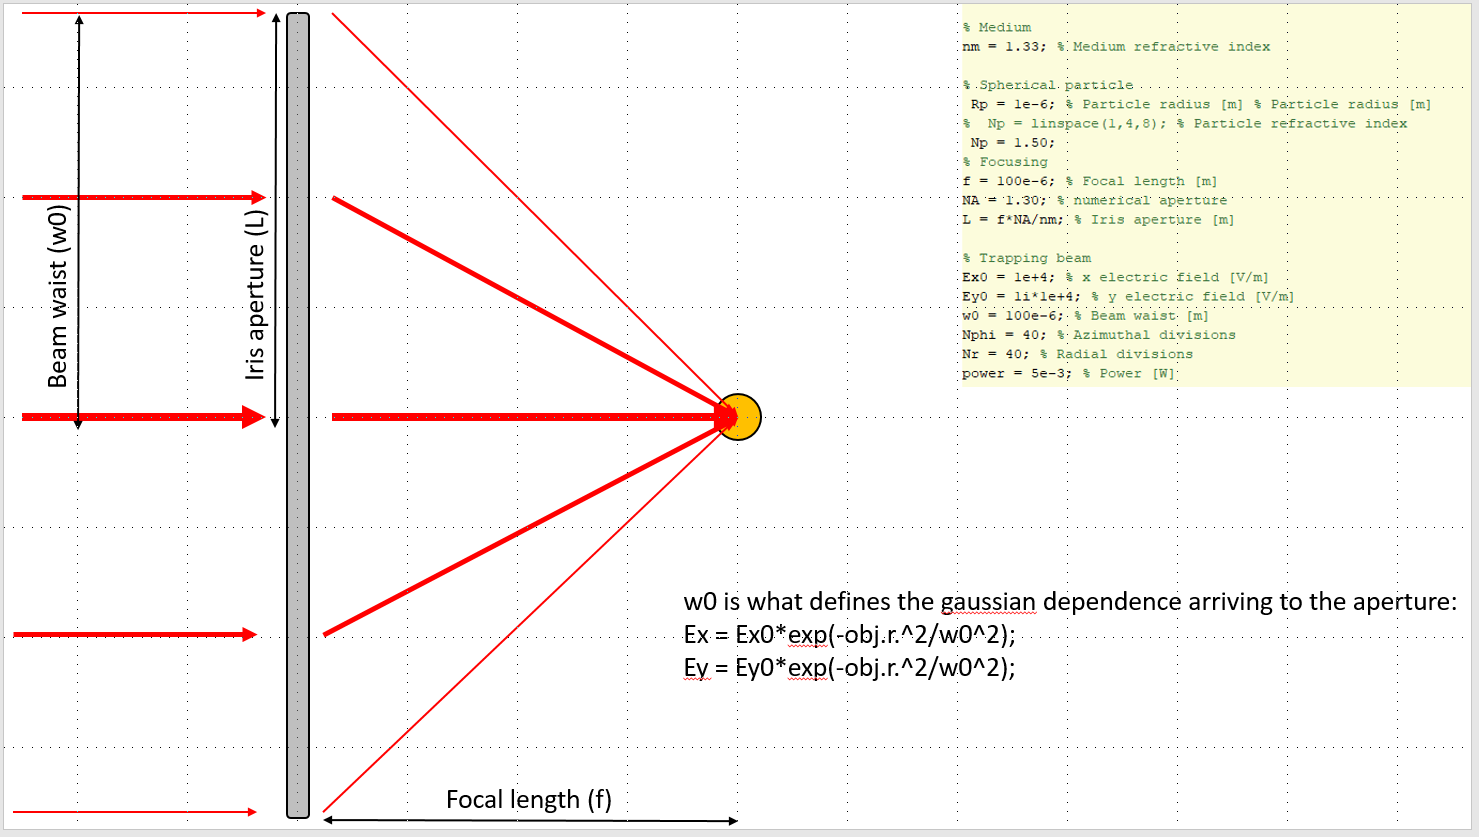

Let's compute the forces across one axis

In [40]:
X_axis=np.zeros([101,3])
X_axis[:,0]=np.linspace(-4,4,101)

In [41]:
Forces_X_axis=model10_sphere.predict(X_axis)

4/4 [==============================] - 2s 9ms/step


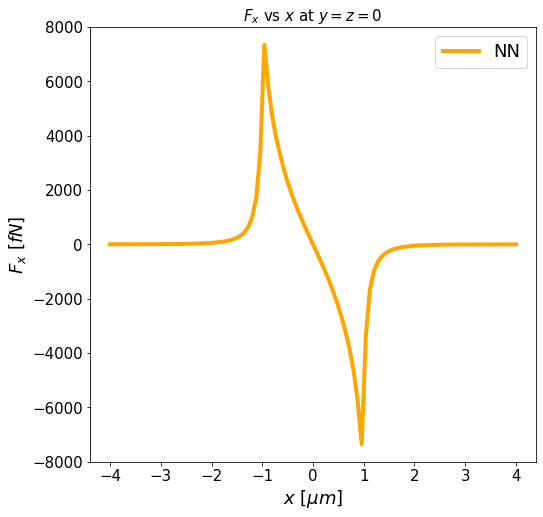

In [45]:
plt.plot(X_axis[:,0],Forces_X_axis[:,0],c='orange',linewidth=4)
plt.legend(['NN'])

plt.title('$F_x$ vs $x$ at $y=z=0$')
plt.xlabel('$x$ $[\mu m]$')
plt.ylabel('$F_x$ $[fN]$')

plt.ylim([-8000,8000])

plt.gcf().set_size_inches(8, 8)

We can redefine the parameters of our simulation

In [46]:
PowerAfterTheObjective=0.001 # [W]
CorrectionForThePower=PowerAfterTheObjective/0.005

kB=1.3806E-23       # [(kg·m^2)/(K·s^2)]
T = 273+20          # [K]
Radius = 1E-6    # [m]
#Check viscosity value
Viscosity = 0.00002414*10**(247.8/(-140+T))  # [Pa·s]
Gamma = 6*math.pi*Viscosity*Radius
D=kB*T/Gamma

We define the variables where we will store the trajectories:

In [49]:
N=500 #numero di punti nel tempo
Experiments=1 #numero di esperimenti simulati

delta_t=0.001

x_trapped=np.zeros([Experiments,N])
y_trapped=np.zeros([Experiments,N])
z_trapped=np.zeros([Experiments,N])

We simulate the trajectories. The code is not optimized for computational speed but for clarity. The first loop goes over the number of trajectories we are computing, the second loop goes over the total number of time steps. We need to calculate the forces with the proper units (both in the input and the output), and once we have done this we can include the optical contribution in the dynamics. For simplicity, let's assume we are trapping against a wall ($z=0$).

In [50]:
for exp in range (0,Experiments):
    for t in range (1,N):
        PointPrev=[x_trapped[exp,t-1]*1e6,y_trapped[exp,t-1]*1e6,z_trapped[exp,t-1]*1e6]
        ForcesNN=model10_sphere.predict([PointPrev])/1e15
        
        x_trapped[exp,t]=x_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][0]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        y_trapped[exp,t]=y_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][1]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        z_trapped[exp,t]=0
        print(t)

1/1 [==============================] - 0s 38ms/step
1
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 37ms/step
3
1/1 [==============================] - 0s 37ms/step
4
1/1 [==============================] - 0s 36ms/step
5
1/1 [==============================] - 0s 42ms/step
6
1/1 [==============================] - 0s 39ms/step
7
1/1 [==============================] - 0s 38ms/step
8
1/1 [==============================] - 0s 38ms/step
9
1/1 [==============================] - 0s 40ms/step
10
1/1 [==============================] - 0s 43ms/step
11
1/1 [==============================] - 0s 43ms/step
12
1/1 [==============================] - 0s 53ms/step
13
1/1 [==============================] - 0s 50ms/step
14
1/1 [==============================] - 0s 38ms/step
15
1/1 [==============================] - 0s 46ms/step
16
1/1 [==============================] - 0s 43ms/step
17
1/1 [==============================] - 0s 37ms/step
18
1/1 [==============

1/1 [==============================] - 0s 42ms/step
295
1/1 [==============================] - 0s 40ms/step
296
1/1 [==============================] - 0s 42ms/step
297
1/1 [==============================] - 0s 41ms/step
298
1/1 [==============================] - 0s 41ms/step
299
1/1 [==============================] - 0s 38ms/step
300
1/1 [==============================] - 0s 38ms/step
301
1/1 [==============================] - 0s 38ms/step
302
1/1 [==============================] - 0s 40ms/step
303
1/1 [==============================] - 0s 38ms/step
304
1/1 [==============================] - 0s 40ms/step
305
1/1 [==============================] - 0s 48ms/step
306
1/1 [==============================] - 0s 38ms/step
307
1/1 [==============================] - 0s 40ms/step
308
1/1 [==============================] - 0s 36ms/step
309
1/1 [==============================] - 0s 43ms/step
310
1/1 [==============================] - 0s 38ms/step
311
1/1 [==============================] - 0s 37ms/s

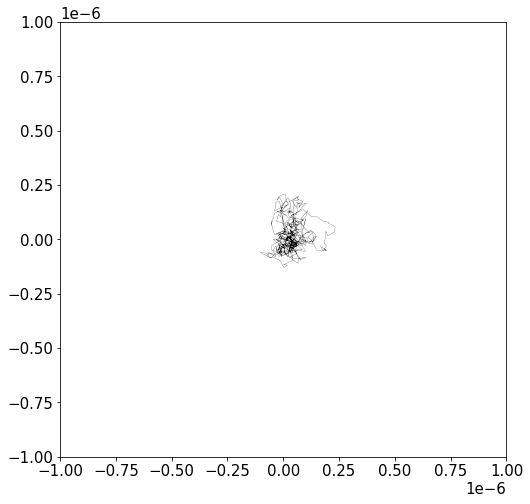

In [51]:
plt.plot(x_trapped[0,:],y_trapped[0,:], 'k',linewidth=0.2)

plt.xlim([-1e-6,1e-6])
plt.ylim([-1e-6,1e-6])

plt.gcf().set_size_inches(8, 8)

Let's include some activity in the particle. First, we assume that the particle is always swimming in one direction. Imagine for example that the orientation is fixed by a magnetic field.

In [55]:
swimming_velocity=100e-6

for exp in range (0,Experiments):
    for t in range (1,N):
        PointPrev=[x_trapped[exp,t-1]*1e6,y_trapped[exp,t-1]*1e6,z_trapped[exp,t-1]*1e6]
        ForcesNN=model10_sphere.predict([PointPrev])/1e15
        
        x_trapped[exp,t]=x_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][0]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)+swimming_velocity*delta_t
        y_trapped[exp,t]=y_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][1]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        z_trapped[exp,t]=0
        print(t)

1/1 [==============================] - 0s 41ms/step
1
1/1 [==============================] - 0s 36ms/step
2
1/1 [==============================] - 0s 35ms/step
3
1/1 [==============================] - 0s 36ms/step
4
1/1 [==============================] - 0s 35ms/step
5
1/1 [==============================] - 0s 35ms/step
6
1/1 [==============================] - 0s 41ms/step
7
1/1 [==============================] - 0s 40ms/step
8
1/1 [==============================] - 0s 38ms/step
9
1/1 [==============================] - 0s 38ms/step
10
1/1 [==============================] - 0s 36ms/step
11
1/1 [==============================] - 0s 40ms/step
12
1/1 [==============================] - 0s 41ms/step
13
1/1 [==============================] - 0s 45ms/step
14
1/1 [==============================] - 0s 43ms/step
15
1/1 [==============================] - 0s 42ms/step
16
1/1 [==============================] - 0s 41ms/step
17
1/1 [==============================] - 0s 40ms/step
18
1/1 [==============

1/1 [==============================] - 0s 39ms/step
295
1/1 [==============================] - 0s 40ms/step
296
1/1 [==============================] - 0s 54ms/step
297
1/1 [==============================] - 0s 44ms/step
298
1/1 [==============================] - 0s 40ms/step
299
1/1 [==============================] - 0s 43ms/step
300
1/1 [==============================] - 0s 36ms/step
301
1/1 [==============================] - 0s 36ms/step
302
1/1 [==============================] - 0s 36ms/step
303
1/1 [==============================] - 0s 40ms/step
304
1/1 [==============================] - 0s 42ms/step
305
1/1 [==============================] - 0s 37ms/step
306
1/1 [==============================] - 0s 39ms/step
307
1/1 [==============================] - 0s 42ms/step
308
1/1 [==============================] - 0s 39ms/step
309
1/1 [==============================] - 0s 40ms/step
310
1/1 [==============================] - 0s 39ms/step
311
1/1 [==============================] - 0s 36ms/s

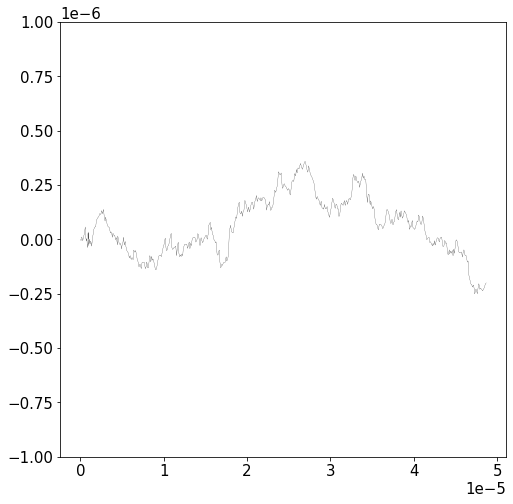

In [58]:
plt.plot(x_trapped[0,:],y_trapped[0,:], 'k',linewidth=0.2)

#plt.xlim([-1e-6,1e-6])
plt.ylim([-1e-6,1e-6])

plt.gcf().set_size_inches(8, 8)

Now let's assume that there is a force that makes the swimming speed to be always pointing outwards.

In [63]:
N=5000 #numero di punti nel tempo
Experiments=1 #numero di esperimenti simulati

delta_t=0.001

x_trapped=np.zeros([Experiments,N])
y_trapped=np.zeros([Experiments,N])
z_trapped=np.zeros([Experiments,N])

In [64]:
def get_angle(x,y):
    angle=np.arctan2(y,x)
    return (angle)

In [65]:
swimming_velocity=10e-6

for exp in range (0,Experiments):
    for t in range (1,N):
        PointPrev=[x_trapped[exp,t-1]*1e6,y_trapped[exp,t-1]*1e6,z_trapped[exp,t-1]*1e6]
        ForcesNN=model10_sphere.predict([PointPrev])/1e15
        
        AnglePartFoR=get_angle(x_trapped[exp,t-1],y_trapped[exp,t-1])
        SwimmingVelocityContrinutionX=swimming_velocity*np.cos(AnglePartFoR)
        SwimmingVelocityContrinutionY=swimming_velocity*np.sin(AnglePartFoR)
        
        x_trapped[exp,t]=x_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][0]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)+SwimmingVelocityContrinutionX*delta_t
        y_trapped[exp,t]=y_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][1]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)+SwimmingVelocityContrinutionY*delta_t
        z_trapped[exp,t]=0
        print(t)

1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 36ms/step
2
1/1 [==============================] - 0s 37ms/step
3
1/1 [==============================] - 0s 36ms/step
4
1/1 [==============================] - 0s 40ms/step
5
1/1 [==============================] - 0s 39ms/step
6
1/1 [==============================] - 0s 37ms/step
7
1/1 [==============================] - 0s 37ms/step
8
1/1 [==============================] - 0s 41ms/step
9
1/1 [==============================] - 0s 48ms/step
10
1/1 [==============================] - 0s 50ms/step
11
1/1 [==============================] - 0s 47ms/step
12
1/1 [==============================] - 0s 38ms/step
13
1/1 [==============================] - 0s 43ms/step
14
1/1 [==============================] - 0s 49ms/step
15
1/1 [==============================] - 0s 50ms/step
16
1/1 [==============================] - 0s 36ms/step
17
1/1 [==============================] - 0s 41ms/step
18
1/1 [==============

1/1 [==============================] - 0s 43ms/step
295
1/1 [==============================] - 0s 38ms/step
296
1/1 [==============================] - 0s 38ms/step
297
1/1 [==============================] - 0s 36ms/step
298
1/1 [==============================] - 0s 46ms/step
299
1/1 [==============================] - 0s 40ms/step
300
1/1 [==============================] - 0s 39ms/step
301
1/1 [==============================] - 0s 36ms/step
302
1/1 [==============================] - 0s 41ms/step
303
1/1 [==============================] - 0s 40ms/step
304
1/1 [==============================] - 0s 38ms/step
305
1/1 [==============================] - 0s 40ms/step
306
1/1 [==============================] - 0s 40ms/step
307
1/1 [==============================] - 0s 39ms/step
308
1/1 [==============================] - 0s 38ms/step
309
1/1 [==============================] - 0s 38ms/step
310
1/1 [==============================] - 0s 43ms/step
311
1/1 [==============================] - 0s 37ms/s

1/1 [==============================] - 0s 45ms/step
587
1/1 [==============================] - 0s 45ms/step
588
1/1 [==============================] - 0s 34ms/step
589
1/1 [==============================] - 0s 39ms/step
590
1/1 [==============================] - 0s 36ms/step
591
1/1 [==============================] - 0s 39ms/step
592
1/1 [==============================] - 0s 43ms/step
593
1/1 [==============================] - 0s 39ms/step
594
1/1 [==============================] - 0s 39ms/step
595
1/1 [==============================] - 0s 39ms/step
596
1/1 [==============================] - 0s 41ms/step
597
1/1 [==============================] - 0s 40ms/step
598
1/1 [==============================] - 0s 42ms/step
599
1/1 [==============================] - 0s 42ms/step
600
1/1 [==============================] - 0s 40ms/step
601
1/1 [==============================] - 0s 41ms/step
602
1/1 [==============================] - 0s 42ms/step
603
1/1 [==============================] - 0s 40ms/s

1/1 [==============================] - 0s 41ms/step
879
1/1 [==============================] - 0s 37ms/step
880
1/1 [==============================] - 0s 41ms/step
881
1/1 [==============================] - 0s 38ms/step
882
1/1 [==============================] - 0s 39ms/step
883
1/1 [==============================] - 0s 39ms/step
884
1/1 [==============================] - 0s 36ms/step
885
1/1 [==============================] - 0s 40ms/step
886
1/1 [==============================] - 0s 36ms/step
887
1/1 [==============================] - 0s 43ms/step
888
1/1 [==============================] - 0s 42ms/step
889
1/1 [==============================] - 0s 38ms/step
890
1/1 [==============================] - 0s 40ms/step
891
1/1 [==============================] - 0s 41ms/step
892
1/1 [==============================] - 0s 35ms/step
893
1/1 [==============================] - 0s 39ms/step
894
1/1 [==============================] - 0s 41ms/step
895
1/1 [==============================] - 0s 39ms/s

1024
1/1 [==============================] - 0s 42ms/step
1025
1/1 [==============================] - 0s 42ms/step
1026
1/1 [==============================] - 0s 39ms/step
1027
1/1 [==============================] - 0s 39ms/step
1028
1/1 [==============================] - 0s 41ms/step
1029
1/1 [==============================] - 0s 37ms/step
1030
1/1 [==============================] - 0s 37ms/step
1031
1/1 [==============================] - 0s 41ms/step
1032
1/1 [==============================] - 0s 40ms/step
1033
1/1 [==============================] - 0s 39ms/step
1034
1/1 [==============================] - 0s 40ms/step
1035
1/1 [==============================] - 0s 42ms/step
1036
1/1 [==============================] - 0s 39ms/step
1037
1/1 [==============================] - 0s 39ms/step
1038
1/1 [==============================] - 0s 38ms/step
1039
1/1 [==============================] - 0s 39ms/step
1040
1/1 [==============================] - 0s 35ms/step
1041
1/1 [=====================

1/1 [==============================] - 0s 44ms/step
1311
1/1 [==============================] - 0s 44ms/step
1312
1/1 [==============================] - 0s 45ms/step
1313
1/1 [==============================] - 0s 43ms/step
1314
1/1 [==============================] - 0s 45ms/step
1315
1/1 [==============================] - 0s 41ms/step
1316
1/1 [==============================] - 0s 40ms/step
1317
1/1 [==============================] - 0s 38ms/step
1318
1/1 [==============================] - 0s 42ms/step
1319
1/1 [==============================] - 0s 39ms/step
1320
1/1 [==============================] - 0s 42ms/step
1321
1/1 [==============================] - 0s 39ms/step
1322
1/1 [==============================] - 0s 42ms/step
1323
1/1 [==============================] - 0s 41ms/step
1324
1/1 [==============================] - 0s 49ms/step
1325
1/1 [==============================] - 0s 45ms/step
1326
1/1 [==============================] - 0s 49ms/step
1327
1/1 [==========================

1/1 [==============================] - 0s 41ms/step
1597
1/1 [==============================] - 0s 41ms/step
1598
1/1 [==============================] - 0s 40ms/step
1599
1/1 [==============================] - 0s 42ms/step
1600
1/1 [==============================] - 0s 40ms/step
1601
1/1 [==============================] - 0s 40ms/step
1602
1/1 [==============================] - 0s 40ms/step
1603
1/1 [==============================] - 0s 40ms/step
1604
1/1 [==============================] - 0s 43ms/step
1605
1/1 [==============================] - 0s 40ms/step
1606
1/1 [==============================] - 0s 39ms/step
1607
1/1 [==============================] - 0s 41ms/step
1608
1/1 [==============================] - 0s 43ms/step
1609
1/1 [==============================] - 0s 39ms/step
1610
1/1 [==============================] - 0s 43ms/step
1611
1/1 [==============================] - 0s 43ms/step
1612
1/1 [==============================] - 0s 40ms/step
1613
1/1 [==========================

1/1 [==============================] - 0s 39ms/step
1883
1/1 [==============================] - 0s 40ms/step
1884
1/1 [==============================] - 0s 40ms/step
1885
1/1 [==============================] - 0s 36ms/step
1886
1/1 [==============================] - 0s 38ms/step
1887
1/1 [==============================] - 0s 41ms/step
1888
1/1 [==============================] - 0s 44ms/step
1889
1/1 [==============================] - 0s 38ms/step
1890
1/1 [==============================] - 0s 41ms/step
1891
1/1 [==============================] - 0s 39ms/step
1892
1/1 [==============================] - 0s 38ms/step
1893
1/1 [==============================] - 0s 42ms/step
1894
1/1 [==============================] - 0s 39ms/step
1895
1/1 [==============================] - 0s 40ms/step
1896
1/1 [==============================] - 0s 39ms/step
1897
1/1 [==============================] - 0s 36ms/step
1898
1/1 [==============================] - 0s 39ms/step
1899
1/1 [==========================

1/1 [==============================] - 0s 40ms/step
2169
1/1 [==============================] - 0s 40ms/step
2170
1/1 [==============================] - 0s 35ms/step
2171
1/1 [==============================] - 0s 38ms/step
2172
1/1 [==============================] - 0s 37ms/step
2173
1/1 [==============================] - 0s 40ms/step
2174
1/1 [==============================] - 0s 41ms/step
2175
1/1 [==============================] - 0s 39ms/step
2176
1/1 [==============================] - 0s 40ms/step
2177
1/1 [==============================] - 0s 42ms/step
2178
1/1 [==============================] - 0s 37ms/step
2179
1/1 [==============================] - 0s 39ms/step
2180
1/1 [==============================] - 0s 37ms/step
2181
1/1 [==============================] - 0s 39ms/step
2182
1/1 [==============================] - 0s 40ms/step
2183
1/1 [==============================] - 0s 41ms/step
2184
1/1 [==============================] - 0s 40ms/step
2185
1/1 [==========================

1/1 [==============================] - 0s 36ms/step
2455
1/1 [==============================] - 0s 39ms/step
2456
1/1 [==============================] - 0s 40ms/step
2457
1/1 [==============================] - 0s 38ms/step
2458
1/1 [==============================] - 0s 37ms/step
2459
1/1 [==============================] - 0s 40ms/step
2460
1/1 [==============================] - 0s 44ms/step
2461
1/1 [==============================] - 0s 39ms/step
2462
1/1 [==============================] - 0s 38ms/step
2463
1/1 [==============================] - 0s 40ms/step
2464
1/1 [==============================] - 0s 36ms/step
2465
1/1 [==============================] - 0s 36ms/step
2466
1/1 [==============================] - 0s 38ms/step
2467
1/1 [==============================] - 0s 39ms/step
2468
1/1 [==============================] - 0s 39ms/step
2469
1/1 [==============================] - 0s 36ms/step
2470
1/1 [==============================] - 0s 38ms/step
2471
1/1 [==========================

1/1 [==============================] - 0s 40ms/step
2741
1/1 [==============================] - 0s 42ms/step
2742
1/1 [==============================] - 0s 40ms/step
2743
1/1 [==============================] - 0s 40ms/step
2744
1/1 [==============================] - 0s 40ms/step
2745
1/1 [==============================] - 0s 37ms/step
2746
1/1 [==============================] - 0s 39ms/step
2747
1/1 [==============================] - 0s 38ms/step
2748
1/1 [==============================] - 0s 42ms/step
2749
1/1 [==============================] - 0s 36ms/step
2750
1/1 [==============================] - 0s 38ms/step
2751
1/1 [==============================] - 0s 40ms/step
2752
1/1 [==============================] - 0s 41ms/step
2753
1/1 [==============================] - 0s 39ms/step
2754
1/1 [==============================] - 0s 41ms/step
2755
1/1 [==============================] - 0s 36ms/step
2756
1/1 [==============================] - 0s 39ms/step
2757
1/1 [==========================

1/1 [==============================] - 0s 37ms/step
3027
1/1 [==============================] - 0s 38ms/step
3028
1/1 [==============================] - 0s 41ms/step
3029
1/1 [==============================] - 0s 43ms/step
3030
1/1 [==============================] - 0s 39ms/step
3031
1/1 [==============================] - 0s 42ms/step
3032
1/1 [==============================] - 0s 38ms/step
3033
1/1 [==============================] - 0s 39ms/step
3034
1/1 [==============================] - 0s 40ms/step
3035
1/1 [==============================] - 0s 38ms/step
3036
1/1 [==============================] - 0s 36ms/step
3037
1/1 [==============================] - 0s 39ms/step
3038
1/1 [==============================] - 0s 40ms/step
3039
1/1 [==============================] - 0s 35ms/step
3040
1/1 [==============================] - 0s 38ms/step
3041
1/1 [==============================] - 0s 40ms/step
3042
1/1 [==============================] - 0s 39ms/step
3043
1/1 [==========================

1/1 [==============================] - 0s 41ms/step
3313
1/1 [==============================] - 0s 39ms/step
3314
1/1 [==============================] - 0s 43ms/step
3315
1/1 [==============================] - 0s 39ms/step
3316
1/1 [==============================] - 0s 39ms/step
3317
1/1 [==============================] - 0s 45ms/step
3318
1/1 [==============================] - 0s 42ms/step
3319
1/1 [==============================] - 0s 39ms/step
3320
1/1 [==============================] - 0s 38ms/step
3321
1/1 [==============================] - 0s 40ms/step
3322
1/1 [==============================] - 0s 37ms/step
3323
1/1 [==============================] - 0s 42ms/step
3324
1/1 [==============================] - 0s 36ms/step
3325
1/1 [==============================] - 0s 43ms/step
3326
1/1 [==============================] - 0s 36ms/step
3327
1/1 [==============================] - 0s 39ms/step
3328
1/1 [==============================] - 0s 39ms/step
3329
1/1 [==========================

1/1 [==============================] - 0s 37ms/step
3599
1/1 [==============================] - 0s 39ms/step
3600
1/1 [==============================] - 0s 42ms/step
3601
1/1 [==============================] - 0s 38ms/step
3602
1/1 [==============================] - 0s 37ms/step
3603
1/1 [==============================] - 0s 42ms/step
3604
1/1 [==============================] - 0s 37ms/step
3605
1/1 [==============================] - 0s 36ms/step
3606
1/1 [==============================] - 0s 40ms/step
3607
1/1 [==============================] - 0s 41ms/step
3608
1/1 [==============================] - 0s 36ms/step
3609
1/1 [==============================] - 0s 39ms/step
3610
1/1 [==============================] - 0s 36ms/step
3611
1/1 [==============================] - 0s 36ms/step
3612
1/1 [==============================] - 0s 40ms/step
3613
1/1 [==============================] - 0s 40ms/step
3614
1/1 [==============================] - 0s 43ms/step
3615
1/1 [==========================

1/1 [==============================] - 0s 40ms/step
3885
1/1 [==============================] - 0s 37ms/step
3886
1/1 [==============================] - 0s 37ms/step
3887
1/1 [==============================] - 0s 36ms/step
3888
1/1 [==============================] - 0s 39ms/step
3889
1/1 [==============================] - 0s 38ms/step
3890
1/1 [==============================] - 0s 41ms/step
3891
1/1 [==============================] - 0s 40ms/step
3892
1/1 [==============================] - 0s 41ms/step
3893
1/1 [==============================] - 0s 38ms/step
3894
1/1 [==============================] - 0s 40ms/step
3895
1/1 [==============================] - 0s 39ms/step
3896
1/1 [==============================] - 0s 40ms/step
3897
1/1 [==============================] - 0s 39ms/step
3898
1/1 [==============================] - 0s 37ms/step
3899
1/1 [==============================] - 0s 38ms/step
3900
1/1 [==============================] - 0s 36ms/step
3901
1/1 [==========================

1/1 [==============================] - 0s 39ms/step
4171
1/1 [==============================] - 0s 43ms/step
4172
1/1 [==============================] - 0s 36ms/step
4173
1/1 [==============================] - 0s 35ms/step
4174
1/1 [==============================] - 0s 41ms/step
4175
1/1 [==============================] - 0s 42ms/step
4176
1/1 [==============================] - 0s 39ms/step
4177
1/1 [==============================] - 0s 36ms/step
4178
1/1 [==============================] - 0s 38ms/step
4179
1/1 [==============================] - 0s 39ms/step
4180
1/1 [==============================] - 0s 39ms/step
4181
1/1 [==============================] - 0s 37ms/step
4182
1/1 [==============================] - 0s 38ms/step
4183
1/1 [==============================] - 0s 39ms/step
4184
1/1 [==============================] - 0s 38ms/step
4185
1/1 [==============================] - 0s 38ms/step
4186
1/1 [==============================] - 0s 42ms/step
4187
1/1 [==========================

1/1 [==============================] - 0s 42ms/step
4457
1/1 [==============================] - 0s 40ms/step
4458
1/1 [==============================] - 0s 40ms/step
4459
1/1 [==============================] - 0s 43ms/step
4460
1/1 [==============================] - 0s 39ms/step
4461
1/1 [==============================] - 0s 39ms/step
4462
1/1 [==============================] - 0s 39ms/step
4463
1/1 [==============================] - 0s 43ms/step
4464
1/1 [==============================] - 0s 39ms/step
4465
1/1 [==============================] - 0s 37ms/step
4466
1/1 [==============================] - 0s 40ms/step
4467
1/1 [==============================] - 0s 41ms/step
4468
1/1 [==============================] - 0s 41ms/step
4469
1/1 [==============================] - 0s 40ms/step
4470
1/1 [==============================] - 0s 39ms/step
4471
1/1 [==============================] - 0s 41ms/step
4472
1/1 [==============================] - 0s 36ms/step
4473
1/1 [==========================

1/1 [==============================] - 0s 40ms/step
4743
1/1 [==============================] - 0s 39ms/step
4744
1/1 [==============================] - 0s 41ms/step
4745
1/1 [==============================] - 0s 44ms/step
4746
1/1 [==============================] - 0s 47ms/step
4747
1/1 [==============================] - 0s 44ms/step
4748
1/1 [==============================] - 0s 48ms/step
4749
1/1 [==============================] - 0s 44ms/step
4750
1/1 [==============================] - 0s 46ms/step
4751
1/1 [==============================] - 0s 42ms/step
4752
1/1 [==============================] - 0s 39ms/step
4753
1/1 [==============================] - 0s 42ms/step
4754
1/1 [==============================] - 0s 41ms/step
4755
1/1 [==============================] - 0s 39ms/step
4756
1/1 [==============================] - 0s 37ms/step
4757
1/1 [==============================] - 0s 39ms/step
4758
1/1 [==============================] - 0s 44ms/step
4759
1/1 [==========================

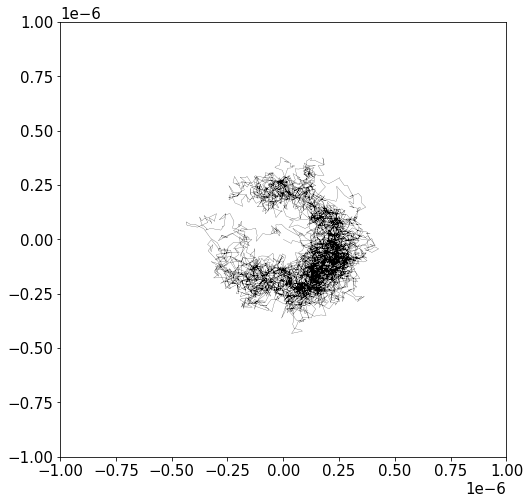

In [66]:
plt.plot(x_trapped[0,:],y_trapped[0,:], 'k',linewidth=0.2)

plt.xlim([-1e-6,1e-6])
plt.ylim([-1e-6,1e-6])

plt.gcf().set_size_inches(8, 8)